In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# 1) NPZ読み込み（CWT保存ファイル）
#   - あなたのノートの保存形式：
#       features_cwt.npz に
#       Xcwt_tr, Xcwt_te, Xcwt_tr_n, Xcwt_te_n, scales, freqs, ... が入る想定
# ============================================================
def load_cwt_npz(npz_path="features_cwt.npz", use_normalized=True):
    z = np.load(npz_path, allow_pickle=False)

    # 正規化済みがあればそれを優先
    if use_normalized and ("Xcwt_tr_n" in z) and ("Xcwt_te_n" in z):
        Xtr = z["Xcwt_tr_n"]
        Xte = z["Xcwt_te_n"]
        src = "normalized (Xcwt_*_n)"
    else:
        Xtr = z["Xcwt_tr"]
        Xte = z["Xcwt_te"]
        src = "raw (Xcwt_*)"

    info = {}
    for k in ["scales", "freqs", "FS", "mean", "std"]:
        if k in z:
            info[k] = z[k]

    return Xtr, Xte, info, src


# ============================================================
# 2) 入力整形
#   Dense AE に入れるなら (N,S,T,C) を (N, L) に平坦化するのが一番簡単
#   - L = S*T*C
#   - Cが無い場合 (N,S,T) なら L = S*T
# ============================================================
def flatten_cwt(X):
    if X.ndim == 4:   # (N,S,T,C)
        return X.reshape(X.shape[0], -1)
    if X.ndim == 3:   # (N,S,T)
        return X.reshape(X.shape[0], -1)
    if X.ndim == 2:   # (N,L) すでに平坦
        return X
    raise ValueError(f"想定外のshapeです: {X.shape}")


# ============================================================
# 3) train/val 分割（sklearn無しで動く版）
# ============================================================
def train_val_split(X, val_ratio=0.2, seed=21):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(X.shape[0])
    n_val = int(round(X.shape[0] * val_ratio))
    val_idx = idx[:n_val]
    tr_idx  = idx[n_val:]
    return X[tr_idx], X[val_idx]


# ============================================================
# 4) Dense AutoEncoder（設計を触りやすい Functional）
#   - 各Dense層が覚えるもの：重みW と バイアスb
#       y = activation(XW + b)
#     ここで W,b が学習パラメータ（データそのものを保存するわけではない）
#
#   - なぜ 64-32-16 のように段階的にするか：
#     一気に小さくすると「復元に必要な情報の通り道」が急に狭まり学習が不安定になりやすい。
#     段階的に圧縮すると、粗い特徴→より要点、の順で表現を作りやすい（経験則として安定しやすい）。
#
#   - 潜在層は name="latent" 固定：UMAP等で取り出すため
# ============================================================
def build_dense_ae(
    L,
    ENC_DIMS=(256, 64),     # 入力→…→潜在の直前まで（大きすぎるLなら小さめでもOK）
    LATENT_DIM=32,          # ボトルネック
    DEC_DIMS=None,          # NoneならENCの逆順
    activation_hidden="relu",
    activation_latent="linear",   # latentは可視化したいなら線形の方が扱いやすいことが多い
    activation_out="linear"
):
    if DEC_DIMS is None:
        DEC_DIMS = tuple(list(ENC_DIMS)[::-1])

    inp = keras.Input(shape=(L,), name="cwt_flat_input")

    # Encoder
    x = inp
    for i, units in enumerate(ENC_DIMS):
        x = layers.Dense(
            units,
            activation=activation_hidden,
            name=f"enc_dense_{i}_{units}"
        )(x)

    # Latent（ここをUMAP等で取り出す）
    z = layers.Dense(
        LATENT_DIM,
        activation=activation_latent,
        name="latent"
    )(x)

    # Decoder
    x = z
    for i, units in enumerate(DEC_DIMS):
        x = layers.Dense(
            units,
            activation=activation_hidden,
            name=f"dec_dense_{i}_{units}"
        )(x)

    out = layers.Dense(L, activation=activation_out, name="reconstruction")(x)

    autoencoder = keras.Model(inp, out, name="dense_autoencoder")
    encoder = keras.Model(inp, z, name="encoder_for_umap")

    return autoencoder, encoder


# ============================================================
# 5) 学習（正常のみ）＋異常スコア算出
#   異常スコア：再構成誤差（MSE）を「1窓→1値」にする
# ============================================================
def recon_mse(autoencoder, X):
    Xhat = autoencoder.predict(X, verbose=0)
    return np.mean((X - Xhat) ** 2, axis=1)   # (N,)

def fit_ae_and_score(
    X_train_normal,         # (Ntr,L) 正常のみ
    X_test,                 # (Nte,L)
    enc_dims=(256, 64),
    latent_dim=32,
    lr=1e-3,
    batch_size=128,
    epochs=300,
    val_ratio=0.2,
    patience=20,
    seed=21,
    thr_quantile=0.995      # しきい値：正常スコア上位0.5% など
):
    L = X_train_normal.shape[1]

    # train/val 分割（正常データ内で）
    X_tr, X_val = train_val_split(X_train_normal, val_ratio=val_ratio, seed=seed)

    # モデル
    autoencoder, encoder = build_dense_ae(
        L=L,
        ENC_DIMS=enc_dims,
        LATENT_DIM=latent_dim,
        activation_hidden="relu",
        activation_latent="linear",
        activation_out="linear"
    )

    autoencoder.compile(optimizer=keras.optimizers.Adam(lr), loss="mse")

    early = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True
    )

    history = autoencoder.fit(
        X_tr, X_tr,
        validation_data=(X_val, X_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early],
        verbose=1
    )

    # スコア
    score_tr = recon_mse(autoencoder, X_train_normal)
    score_te = recon_mse(autoencoder, X_test)

    # しきい値（正常スコア分布から）
    tau = float(np.quantile(score_tr, thr_quantile))
    is_anom = (score_te > tau)

    result = {
        "autoencoder": autoencoder,
        "encoder": encoder,
        "history": history,
        "score_tr": score_tr,
        "score_te": score_te,
        "threshold": tau,
        "is_anom": is_anom
    }
    return result


# ============================================================
# 6) 可視化（異常スコア）
#   - 時系列の窓番号に対してスコアを表示
#   - しきい値線
#   - 異常判定点を強調
# ============================================================
def plot_scores(score_te, threshold, x=None, title="Anomaly score (recon MSE)", show_points=True):
    if x is None:
        x = np.arange(len(score_te))

    plt.figure(figsize=(12, 4))
    plt.plot(x, score_te, linewidth=1.0)
    plt.axhline(threshold, linewidth=1.5)

    if show_points:
        idx = np.where(score_te > threshold)[0]
        if idx.size > 0:
            plt.scatter(x[idx], score_te[idx], s=18)

    plt.xlabel("window index (or time)")
    plt.ylabel("reconstruction MSE (score)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_train_score_distribution(score_tr, threshold, title="Train score distribution"):
    plt.figure(figsize=(6, 4))
    plt.hist(score_tr, bins=50)
    plt.axvline(threshold, linewidth=1.5)
    plt.xlabel("train reconstruction MSE")
    plt.ylabel("count")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# 7) 実行例：features_cwt.npz から Dense AE で検知して可視化
# ============================================================
# (A) CWTを読み込み
Xcwt_tr, Xcwt_te, info, src = load_cwt_npz("features_cwt.npz", use_normalized=True)
print("CWT source:", src)
print("Xcwt_tr shape:", Xcwt_tr.shape, "Xcwt_te shape:", Xcwt_te.shape)

# (B) Dense AE用に平坦化（N,S,T,C → N,L）
X_train_normal = flatten_cwt(Xcwt_tr).astype(np.float32, copy=False)
X_test         = flatten_cwt(Xcwt_te).astype(np.float32, copy=False)
print("Flattened:", X_train_normal.shape, X_test.shape)

# (C) 学習→スコア
res = fit_ae_and_score(
    X_train_normal=X_train_normal,
    X_test=X_test,
    enc_dims=(256, 64),
    latent_dim=32,
    lr=1e-3,
    batch_size=128,
    epochs=300,
    val_ratio=0.2,
    patience=20,
    seed=21,
    thr_quantile=0.995
)

print("threshold =", res["threshold"])
print("anomaly rate(test) =", float(res["is_anom"].mean()))


CWT source: normalized (Xcwt_*_n)
Xcwt_tr shape: (200, 64, 256, 2) Xcwt_te shape: (1300, 64, 256, 2)
Flattened: (200, 32768) (1300, 32768)
Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - loss: 0.9754 - val_loss: 1.3561
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.1984 - val_loss: 0.4983
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.4883 - val_loss: 0.4063
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.3956 - val_loss: 0.3650
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.3606 - val_loss: 0.3632
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3586 - val_loss: 0.3544
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.3492 - val_loss: 0.3473
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.3428 - val_loss: 0.3427
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3380 - val_loss: 0.3414
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3365 - val_loss: 0.3412
Epoch 11/3

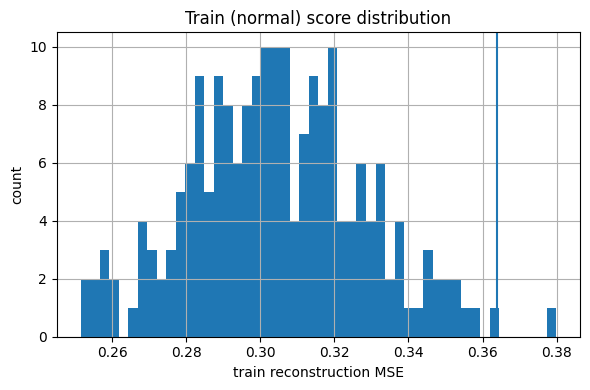

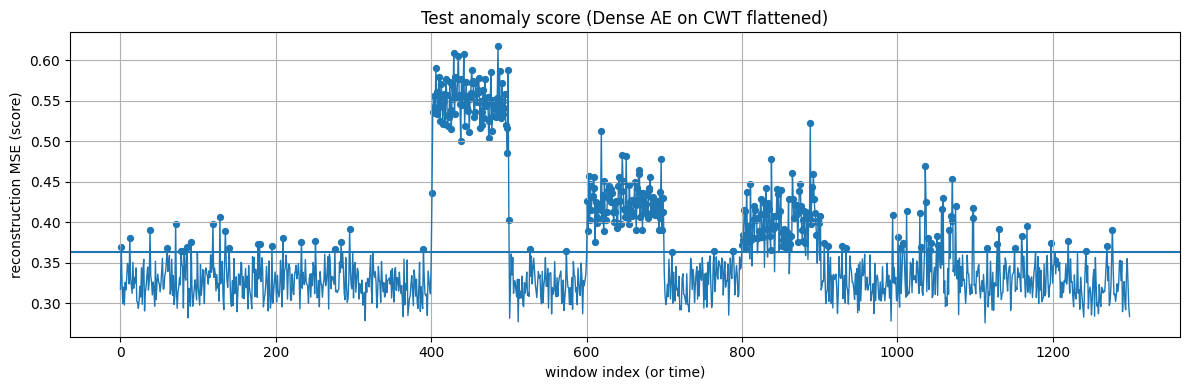

In [3]:

# (D) 可視化
plot_train_score_distribution(res["score_tr"], res["threshold"], title="Train (normal) score distribution")
plot_scores(res["score_te"], res["threshold"], title="Test anomaly score (Dense AE on CWT flattened)")
